<a id='planning'></a>
## Requirements and Planning

- **Write a sql query to acquire data**

    - last transaction during May and June 2017
    
    - single-unit residential properties only
    

- **Figure out state and county for each property**


- **Figure out distribution of tax rates by county**

    - Calculate tax rate using givens of home value and taxes
    
    
- **MVP - Use square feet of home, # of bedrooms, and # of bathrooms to predict home value**

    - Deliverable 1: Presentation slides (Audience == Zillow Team)
    
    - Deliverable 2: Repo containing Jupyter Notebook displaying your work through the pipeline with detailed documentation.
    
    - Deliverable 3: .py modules containing functions that ensure your work is neat, readable, and recreatable.
    
    - Deliverable 4: README.md file with data dictionary
    
    
- $H_0$: Square Feet, Bedroom Count, and Bathroom Count are drivers of Home Value.

- $H_a$: Square Feet, Bedroom Count, and Bathroom Count are not drivers of Home Value.

## Imports

In [1]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,r2_score,explained_variance_score

from statsmodels.formula.api import ols

from math import sqrt
from scipy import stats

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")


import env
import util
from wrangle_zillow import wrangle_zillow
import explore
import split_scale
import features_zillow
import model_zillow
import evaluate

## Acquire and Prep df

- My function, wrangle_zillow, uses the SQL query I created to acquire data from the Zillow database, drop rows containing Null values, and set my columns to the appropriate data types and and desired names.


- My SQL query filtered the Zillow data to include only single unit residential properties whose last transactions were in the months of May and June of 2017. I also filtered out any rows that had a value of zero for bedroomcnt or bathroomcnt which gave me a row count of 15,947.

In [2]:
# I commented this out once I made my csv with my cleaned and prepped df
# df = wrangle_zillow()

df = pd.read_csv('zillow.csv', index_col=0)

In [3]:
print(f'My original dataframe is coming in with {df.shape[0]} rows and {df.shape[1]} columns.')

My original dataframe is coming in with 15947 rows and 10 columns.


In [4]:
df.head()

,bedrooms,bathrooms,square_feet,taxes,home_value,propertylandusedesc,fips_number,zip_code,tax_rate,county_name
0,4.0,2.0,1604,6089.82,498347.0,Single Family Residential,6037,96415.0,0.012220,Los Angeles
1,3.0,3.0,2384,6679.55,549917.0,Single Family Residential,6037,96452.0,0.012146,Los Angeles
2,3.0,2.0,1574,3876.31,235272.0,Single Family Residential,6037,97319.0,0.016476,Los Angeles
3,2.0,2.0,1619,4206.15,340000.0,Single Family Residential,6037,97329.0,0.012371,Los Angeles
4,2.0,3.0,2408,24353.42,2017254.0,Single Family Residential,6037,96086.0,0.012073,Los Angeles


### Summarize the df using tell_me_about(df) function

- My function, tell_me_about(df), allows me to view important descriptive information about my data before I begin to work with it. 

In [5]:
util.tell_me_about(df)

DataFrame Shape:

(15947, 10)

Info about:

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15947 entries, 0 to 15955
Data columns (total 10 columns):
bedrooms               15947 non-null float64
bathrooms              15947 non-null float64
square_feet            15947 non-null int64
taxes                  15947 non-null float64
home_value             15947 non-null float64
propertylandusedesc    15947 non-null object
fips_number            15947 non-null int64
zip_code               15947 non-null float64
tax_rate               15947 non-null float64
county_name            15947 non-null object
dtypes: float64(6), int64(2), object(2)
memory usage: 1.3+ MB
None

Describe:

           bedrooms     bathrooms   square_feet          taxes    home_value  \
count  15947.000000  15947.000000  15947.000000   15947.000000  1.594700e+04   
mean       3.253026      2.215213   1836.276729    5680.471976  4.632920e+05   
std        0.949431      1.025248    980.727638    7466.513817  6.434062e+

In [6]:
# I already took care of this in my SQL query, but free to check...

df.isna().sum()

bedrooms               0
bathrooms              0
square_feet            0
taxes                  0
home_value             0
propertylandusedesc    0
fips_number            0
zip_code               0
tax_rate               0
county_name            0
dtype: int64

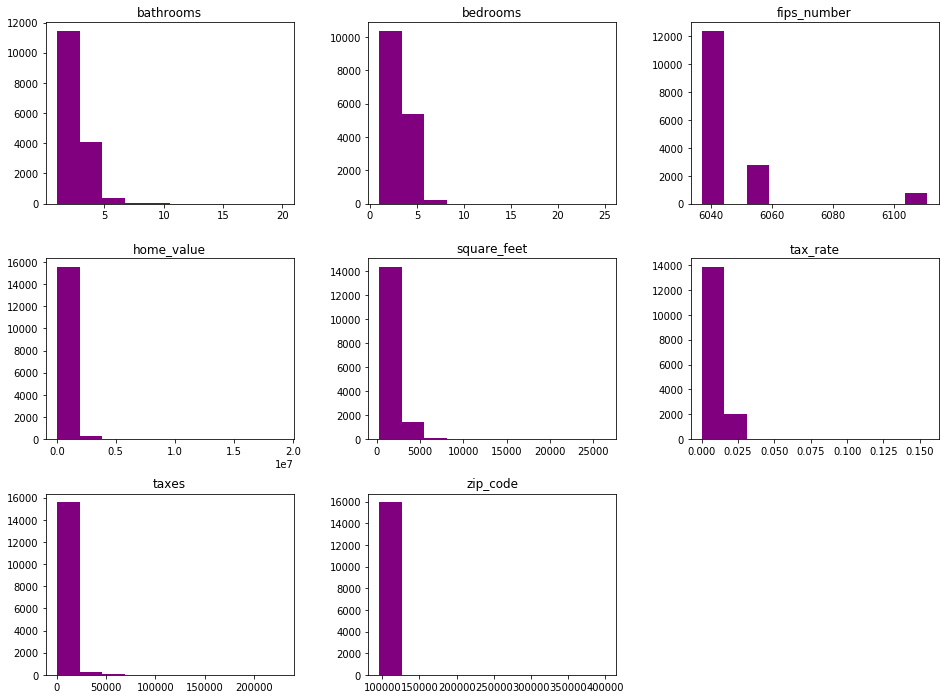

In [7]:
df.hist(grid=False, figsize=(16,12), color='purple')
plt.show()

### I know that my data is all skewed right.

- This may be an indication that I need to transform the data. I might need to log transform the target variable to better predict outliers. This is not something I'm going to worry about in the first iterations of making and evaluating my model and baseline.


- This is something I can keep in mind for improving my models.

### Create a Field that Calculates the Tax Rate

- I will use home value and taxes to create a calculated column to deliver information about the tax rate distribution for each county in my df.

In [8]:
df["tax_rate"] = df["taxes"] / df["home_value"]
df.head()

,bedrooms,bathrooms,square_feet,taxes,home_value,propertylandusedesc,fips_number,zip_code,tax_rate,county_name
0,4.0,2.0,1604,6089.82,498347.0,Single Family Residential,6037,96415.0,0.012220,Los Angeles
1,3.0,3.0,2384,6679.55,549917.0,Single Family Residential,6037,96452.0,0.012146,Los Angeles
2,3.0,2.0,1574,3876.31,235272.0,Single Family Residential,6037,97319.0,0.016476,Los Angeles
3,2.0,2.0,1619,4206.15,340000.0,Single Family Residential,6037,97329.0,0.012371,Los Angeles
4,2.0,3.0,2408,24353.42,2017254.0,Single Family Residential,6037,96086.0,0.012073,Los Angeles


### Add the county name to the df based on the fips number.

In [9]:
df["county_name"] = df["fips_number"].map({6037: "Los Angeles", 6059: "Orange", 6111: "Ventura"})
df.head()

,bedrooms,bathrooms,square_feet,taxes,home_value,propertylandusedesc,fips_number,zip_code,tax_rate,county_name
0,4.0,2.0,1604,6089.82,498347.0,Single Family Residential,6037,96415.0,0.012220,Los Angeles
1,3.0,3.0,2384,6679.55,549917.0,Single Family Residential,6037,96452.0,0.012146,Los Angeles
2,3.0,2.0,1574,3876.31,235272.0,Single Family Residential,6037,97319.0,0.016476,Los Angeles
3,2.0,2.0,1619,4206.15,340000.0,Single Family Residential,6037,97329.0,0.012371,Los Angeles
4,2.0,3.0,2408,24353.42,2017254.0,Single Family Residential,6037,96086.0,0.012073,Los Angeles


### Beautiful! Now I will save my df to csv for future use.

In [10]:
# Commented out because I only needed to make this once. Now I just import my csv for df.
# df.to_csv('zillow.csv')

In [11]:
df = pd.read_csv('zillow.csv', index_col=0)

In [12]:
print(f'My dataframe is coming in from my csv with {df.shape[0]} rows and {df.shape[1]} columns.')

My dataframe is coming in from my csv with 15947 rows and 10 columns.


## Create Distributions of the Tax Rates by County:

- I found the breakdown of fips_numbers at the USDA government site:

https://www.nrcs.usda.gov/wps/portal/nrcs/detail/national/home/?cid=nrcs143_013697
    

- Using the fips_numbers, I found that all three counties represented in my data are in the state of California; they are Los Angeles County, Orange County, and Ventura County.


- I looked at the mean and median tax_rate for each county and found that Los Angeles County has the highest overall tax rate either way. All of the tax rates are similar, though. 


- I looked at the count of properties in each county, and my df is made up of 78% Los Angeles County properties, 17% Orange County, and 5% Ventura County. 


- I also created a function, tax_distribution_viz(df), to take a quick look at the tax rate distributions by county.

In [13]:
county_count = pd.DataFrame(df.groupby("county_name").county_name.count())
county_count.columns = ['count']
county_count['frequency'] = df['county_name'].value_counts(normalize=True)
county_count['percentage'] = round(county_count['frequency'] * 100)

In [14]:
county_count

,count,frequency,percentage
county_name,,,
Los Angeles,12382,0.776447,78.0
Orange,2778,0.174202,17.0
Ventura,787,0.049351,5.0


In [15]:
county_mean_tax_rate = pd.DataFrame(round(df.groupby("county_name").tax_rate.mean(),4)) * 100
county_mean_tax_rate.columns = ['Mean Tax Rate %']

In [16]:
county_median_tax_rate = pd.DataFrame(round(df.groupby("county_name").tax_rate.median(),4)) * 100
county_median_tax_rate.columns = ['Median Tax Rate %']

In [17]:
pd.merge(county_mean_tax_rate, county_median_tax_rate, left_index=True, right_index=True)

,Mean Tax Rate %,Median Tax Rate %
county_name,,
Los Angeles,1.37,1.26
Orange,1.21,1.17
Ventura,1.15,1.12


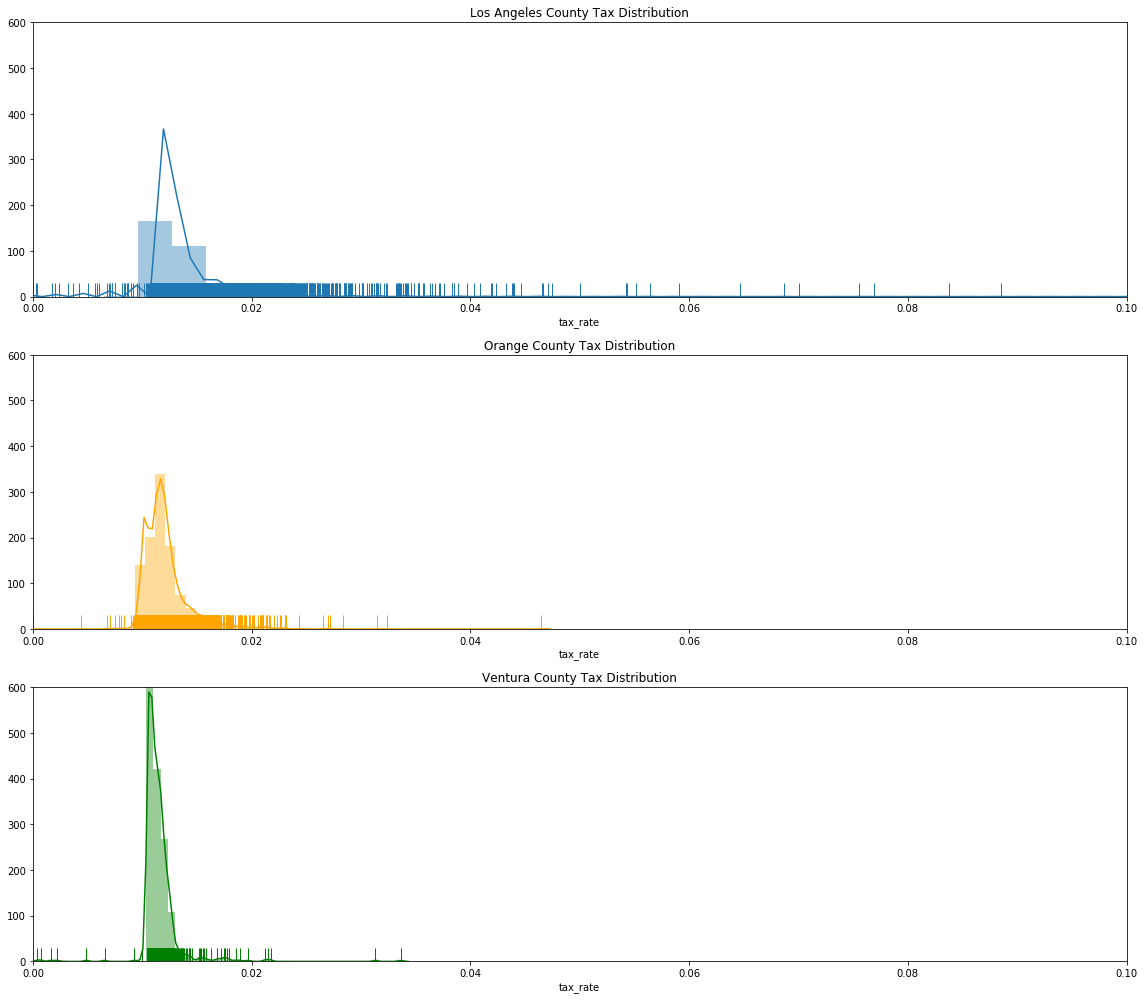

In [18]:
explore.tax_distribution_viz(df)

## Quick and Dirty Linear Regression for Baseline Model

- I have been tasked with making a first model that uses only square feet, # of bedrooms, and # of bathrooms to predict home value. I'm going to do as little exploration and prepping as possible to get this done.


- I will use the mean home value as my first baseline to beat.


- If my evaluation metrics show that my Linear Regression Model is better than using just the baseline value to predict all home values, then I can go back and explore my data more, do any feature engineering and selection I want, and try to beat the performance of my baseline model.

### Split and Scale my df

In [19]:
train, test = split_scale.split_my_data(df)

In [20]:
print(f'My train df is {train.shape} and my test df is {test.shape}.')

My train df is (11162, 10) and my test df is (4785, 10).


In [21]:
train.head(1)

,bedrooms,bathrooms,square_feet,taxes,home_value,propertylandusedesc,fips_number,zip_code,tax_rate,county_name
8731,3.0,2.0,1076,4464.23,383845.0,Single Family Residential,6037,96162.0,0.01163,Los Angeles


In [22]:
test.head(1)

,bedrooms,bathrooms,square_feet,taxes,home_value,propertylandusedesc,fips_number,zip_code,tax_rate,county_name
5402,4.0,3.0,2125,1403.97,91072.0,Single Family Residential,6037,96489.0,0.015416,Los Angeles


In [23]:
X_train = train[['square_feet', 'bedrooms', 'bathrooms']]
X_test = test[['square_feet', 'bedrooms', 'bathrooms']]
y_train = train[['home_value']]
y_test = test[['home_value']]

In [24]:
print(X_train.head(1), X_train.shape)

      square_feet  bedrooms  bathrooms
8731         1076       3.0        2.0 (11162, 3)


In [25]:
print(X_test.head(1), X_test.shape)

      square_feet  bedrooms  bathrooms
5402         2125       4.0        3.0 (4785, 3)


In [26]:
print(y_train.head(1), y_train.shape)

      home_value
8731    383845.0 (11162, 1)


In [27]:
print(y_test.head(1), y_test.shape)

      home_value
5402     91072.0 (4785, 1)


## Quick OLS Model

- Without scaling, without handling any outliers.

- [helpful article](https://nbviewer.jupyter.org/urls/s3.amazonaws.com/datarobotblog/notebooks/multiple_regression_in_python.ipynb)

In [29]:
ols_model = ols(formula='home_value ~ bedrooms + bathrooms + square_feet', data=train).fit()

In [32]:
ols_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             home_value   R-squared:                       0.448
Model:                            OLS   Adj. R-squared:                  0.448
Method:                 Least Squares   F-statistic:                     3015.
Date:                Tue, 07 Apr 2020   Prob (F-statistic):               0.00
Time:                        09:01:50   Log-Likelihood:            -1.6113e+05
No. Observations:               11162   AIC:                         3.223e+05
Df Residuals:                   11158   BIC:                         3.223e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -3.066e+04   1.52e+04     -2.020      0.043   -6.04e+04    -912.879
bedrooms    -1.362e+05   5984.723    -22.758      0.000   -1.48e+05   -1.24e+05
bathrooms    6.953e+04   8320.350      8.356      0.000    5.32e+04    8.58e+04
square_feet   424.7619      8.458     50.219      0.000     408.182     441.341
==============================================================================
Omnibus:                    13750.842   Durbin-Watson:                   1.986
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          4729815.705
Skew:                           6.335   Prob(JB):                         0.00
Kurtosis:                     103.046   Cond. No.                     7.71e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.71e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Let's start with MinMax on X_train and X_test

In [33]:
scaler, X_train_scaled, X_test_scaled = split_scale.min_max_scaler(X_train, X_test)

In [34]:
scaler

MinMaxScaler(copy=True, feature_range=(0, 1))

In [35]:
X_train_scaled.head(3), X_test_scaled.head(3)

(       square_feet  bedrooms  bathrooms
 8731      0.029049  0.083333   0.052632
 10790     0.021210  0.041667   0.000000
 1280      0.022440  0.041667   0.000000,
        square_feet  bedrooms  bathrooms
 5402      0.069356  0.125000   0.105263
 15625     0.024284  0.041667   0.052632
 5300      0.042382  0.083333   0.052632)

### Quick LinearRegression and Baseline Models and Evaluation

In [36]:
predictions, predictions_test = model_zillow.modeling_function(X_train_scaled, y_train, X_test_scaled, y_test)

In [37]:
predictions.head(1)

,actual,lm1,lm_baseline
0,383845.0,156834.791401,456487.606074


In [38]:
predictions_test.head(1)

,actual,lm1_test,lm_baseline_test
0,91072.0,514259.970608,479164.649321


### Coeffcients

In [41]:
lm1.coef_

NameError: name 'lm1' is not defined

### Calculate residuals for train and test - Add to predictions and predictions_test dfs

In [39]:
predictions['residuals'] = predictions.lm1 - predictions.actual
predictions_test['residuals'] = predictions_test.lm1_test - predictions_test.actual

In [40]:
predictions.head(1)

,actual,lm1,lm_baseline,residuals
0,383845.0,156834.791401,456487.606074,-227010.208599


### Visualize Residuals - Look for a Pattern

In [ ]:
evaluate.matplot_residuals(predictions.actual, predictions.residuals)

### It looks like a definite patter in our residuals, so I bet we can do better. We already know that some of our features are correlated, so...

### Evaluate Using RMSE and $R^2$ Score on Train Predictions

In [ ]:
predictions.head(1)

In [ ]:
SSE, ESS, TSS, MSE, RMSE = evaluate.regression_errors(predictions.actual, predictions.lm1)

In [ ]:
bSSE, bMSE, bRMSE = evaluate.baseline_mean_errors(predictions.actual)

In [ ]:
good_model = evaluate.better_than_baseline(predictions.actual, predictions.lm1)
print(f'My Linear Regression model is better than my baseline: {good_model}')

In [ ]:
r2_lm1 = r2_score(predictions.actual, predictions.lm1)
print('Using my Train dataset in my Linear Regression Model')
print()
print(f"{r2_lm1:.2%} of the variance in home value can be explained by the square feet, bedroom count and bathroom count in my Linear Regression Model.")

In [ ]:
print(f'My model\'s RMSE is ${round(RMSE,2)}. That\'s pretty huge!')

### It's True that my Multiple Regression Model is Better than Predicting the Mean of Home Value to be Every Home Value

### Evaluate Using RMSE and $R^2$ Score on Test Predictions

In [ ]:
predictions_test.head(1)

In [ ]:
r2_lm1 = r2_score(predictions_test.actual, predictions_test.lm1_test)
print('Using Test dataset in my Linear Regression Model:')
print()
print(f"{r2_lm1:.2%} of the variance in home value can be explained by the square feet, bedroom count and bathroom count in my Linear Regression Model.")

In [ ]:
tSSE, tESS, tTSS, tMSE, tRMSE = evaluate.regression_errors(predictions_test.actual, predictions_test.lm1_test)

print()
print(f'My model\'s RMSE is ${round(tRMSE,2)}. That\'s pretty huge!')

In [ ]:
tbSSE, tbMSE, tbRMSE = evaluate.baseline_mean_errors(predictions_test.actual)


In [ ]:
good_model_test = evaluate.better_than_baseline(predictions_test.actual, predictions_test.lm1_test)
print(f'My model is better than my baseline using my Test dataset: {good_model_test}')

## Based on these Evaluation Metrics, I fail to reject the Null Hypothesis:

- Square feet, Bedroom Count, and Bathroom Count are Drivers of Home Value.

## At this point, we have met the project requirements for predicting home value using square feet, bedroom count, and bathroom count. Beyond this is 'Nice to have' attempts to improve our model.

## Let's Do some REAL Exploration

In [ ]:
df.head(1)

### Correlation Check

In [ ]:
plt.figure(figsize=(8,6))
sns.heatmap(train.corr(), cmap='Purples', annot=True)
plt.ylim(0, 7)

### Bedroom Count 

- We definitely have some outliers here. How do we want to handle those?!

- Also, I should make a function here probably.

In [ ]:
print(df.bedrooms.value_counts(dropna=False).sort_index())
sns.distplot(df.bedrooms)

### Bathroom Count 

- We definitely have some outliers here, too. How do we want to handle those?!

In [ ]:
print(df.bathrooms.value_counts(dropna=False).sort_index())
sns.distplot(df.bathrooms)
plt.show()

In [ ]:
print(df.square_feet.value_counts(dropna=False, bins=15).sort_index())
sns.distplot(df.square_feet, bins=15)
plt.show()

In [ ]:
explore.correlation_exploration(df, 'bedrooms', 'bathrooms')

In [ ]:
explore.correlation_exploration(df, 'bathrooms', 'square_feet')

In [ ]:
explore.correlation_exploration(df, 'bedrooms', 'square_feet')

### The three features we used in our model are highly correlated with each other, so they really shouldn't ALL be feeding our Linear Regression Model.

- This would be a good place to try some feature engineering.

## Handle Outliers for Bedroom and Bathroom

In [ ]:
sns.boxplot(x=X_train["bedrooms"])

plt.title('Bedroom Count')
plt.show()

In [ ]:
sns.boxplot(x=X_train["bathrooms"])

plt.title('Bathroom Count')
plt.show()

### DFs without Outliers

In [ ]:
# Create Train df Without Outliers for Bedrooms and Bathrooms

no_out_train = train[train.bathrooms <= 8]
no_out_train = no_out_train[no_out_train.bedrooms <= 8]

In [ ]:
# Do the same to X_test

no_out_test = test[test.bathrooms <= 8]
no_out_test = no_out_test[no_out_test.bedrooms <= 8]

In [ ]:
# Separate out Features and Target for Train and Test

no_out_X_train = no_out_train[['bedrooms', 'bathrooms', 'square_feet']]
no_out_y_train = no_out_train[['home_value']]

no_out_X_test = no_out_test[['bedrooms', 'bathrooms', 'square_feet']]
no_out_y_test = no_out_test[['home_value']]

In [ ]:
sns.boxplot(x=no_out_X_train["bedrooms"])

plt.title('Bedroom Count No Outliers')
plt.show()

In [ ]:
print(no_out_X_train.bedrooms.value_counts(dropna=False).sort_index())
sns.distplot(no_out_X_train.bedrooms)
plt.show()

In [ ]:
sns.boxplot(x=no_out_X_train["bathrooms"])

plt.title('Bathroom Count Without Outliers')
plt.show()

In [ ]:
print(no_out_X_train.bathrooms.value_counts(dropna=False).sort_index())
sns.distplot(no_out_X_train.bathrooms)

plt.show()

## Feature Selection

- When I used the outliers in the dataset, my $R^2$ score was .45.

- When I removed bedrooms and bathrooms greater than 5, my $R^2$ score was .33!

- When I removed bedrooms greater than 8, my $R^2$ score was .43

- I'm not sure that removing outliers is the way to go here...

In [ ]:
# Function returns the optimal number of features from X_train and the R^2 Score for a Linear Regression Model

number_of_features, score = features_zillow.optimal_number_of_features(X_train, y_train)

In [ ]:
number_of_features

In [ ]:
selected_features_rfe

In [ ]:
selected_features_rfe, x_train_rfe, no_out_x_test_rfe = features_zillow.optimal_features(no_out_X_train, no_out_X_test, no_out_y_train, 3)

In [ ]:
print(f'The R^2 score using 3 features in our Linear Regression is {round(score, 2)}.')

### Feature Selection Using DFs Without Outliers

In [ ]:
no_out_number_of_features, no_out_score = features_zillow.optimal_number_of_features(no_out_X_train, no_out_y_train)
no_out_number_of_features

In [ ]:
no_out_selected_features_rfe, no_out_x_train_rfe, no_out_x_test_rfe = features_zillow.optimal_features(no_out_X_train, no_out_X_test, no_out_y_train, 3)
no_out_selected_features_rfe

In [ ]:
print(f'The R^2 score using 3 features with outliers handled is {round(no_out_score, 2)}')

### Ok, so feature selection tells us that using the three features we did will get us the highest score... UNLESS, we do some feature engineering.

## Feature Engineering

In [ ]:
X_train.head(1)

## Back to the [Top](#planning)